In [1]:
                                                               
from pathlib import Path
import os

try:
                                                                                 
    PROJECT_DIR = Path(globals().get('_dh', [Path.cwd()])[0]).resolve()
except Exception:
    PROJECT_DIR = Path.cwd().resolve()

                                                                          
DATA_DIR = PROJECT_DIR
os.makedirs(DATA_DIR, exist_ok=True)

print(f"DATA_DIR set to: {DATA_DIR}")


DATA_DIR set to: C:\Users\DELL\OneDrive\Desktop\Final


In [2]:
                                                    
                                                    
import pandas as pd
import numpy as np

                                                                              
DATA_PATH = "."                                                

df_pt      = pd.read_csv(str(DATA_DIR / 'PT_data.cleaned.csv'))
df_engage  = pd.read_csv(str(DATA_DIR / 'engagement_data.csv'),
    parse_dates=["timestamp"]                                              
)
df_user    = pd.read_csv(str(DATA_DIR / 'user.csv'))

                                                                               
for df in (df_pt, df_engage, df_user):
    df.drop(columns=[c for c in df.columns if c.lower().startswith("unnamed")],
            inplace=True, errors="ignore")

                                                                               
TODAY       = pd.Timestamp.today().normalize()                   
ONE_WEEK    = pd.Timedelta(days=7)
print(f"Anchor date (TODAY): {TODAY.date()}")

                                                                              
def quick_overview(df, name, peek_cols=None):
    print(f"\n{name}  –  shape {df.shape}")
    display(df.head())                                        
    if peek_cols:
        print(df[peek_cols].head())
    print("Top 5 missing-value %:")
    display((df.isna().mean()*100).sort_values(ascending=False).head())

quick_overview(df_pt,     "PT_data",     peek_cols=["trainer_id", "specialities"])
quick_overview(df_engage, "engagement_data", peek_cols=["trainer_id", "user_id", "timestamp"])
quick_overview(df_user,   "user_data",   peek_cols=["user_id", "health_goal"])

print("\n✅ STEP 1 complete – data loaded, timestamps parsed, basic sanity checks done.")


Anchor date (TODAY): 2025-08-29

PT_data  –  shape (1000, 8)


,trainer_id,name,videos_count,total_likes,workout_recommendations,athlete_rating,years_experience,specialities
0,1,Trainer 1,247,289134,154,4.2,22,"Prenatal Fitness, Yoga"
1,2,Trainer 2,114,122357,68,4.9,24,HIIT
2,3,Trainer 3,482,473810,43,3.2,8,"Yoga, Functional Training"
3,4,Trainer 4,403,317531,100,4.3,3,Pilates
4,5,Trainer 5,127,116388,141,4.4,3,"Muscle Building, Bodybuilding"


   trainer_id                   specialities
0           1         Prenatal Fitness, Yoga
1           2                           HIIT
2           3      Yoga, Functional Training
3           4                        Pilates
4           5  Muscle Building, Bodybuilding
Top 5 missing-value %:


trainer_id                 0.0
name                       0.0
videos_count               0.0
total_likes                0.0
workout_recommendations    0.0
dtype: float64


engagement_data  –  shape (3120110, 7)


,interaction_id,timestamp,user_id,trainer_id,video_completion_rate,adherence_score,feedback_score
0,1861285,2025-02-28 00:01:00,23879,585,0.632,0.534,3.85
1,393905,2025-02-28 00:01:00,5053,73,0.805,0.792,2.72
2,220603,2025-02-28 00:01:00,2834,475,0.414,0.356,2.94
3,465059,2025-02-28 00:01:00,5967,834,0.413,0.388,4.21
4,1896101,2025-02-28 00:01:00,24327,83,0.635,0.600,3.36


   trainer_id  user_id           timestamp
0         585    23879 2025-02-28 00:01:00
1          73     5053 2025-02-28 00:01:00
2         475     2834 2025-02-28 00:01:00
3         834     5967 2025-02-28 00:01:00
4          83    24327 2025-02-28 00:01:00
Top 5 missing-value %:


interaction_id           0.0
timestamp                0.0
user_id                  0.0
trainer_id               0.0
video_completion_rate    0.0
dtype: float64


user_data  –  shape (40000, 5)


,user_id,age_group,health_goal,baseline_activity_level,engagement_persona
0,1,50+,Flexibility & Mobility,moderate,high
1,2,26-35,General Fitness & Wellness,moderate,medium
2,3,26-35,Injury Recovery & Rehabilitation,moderate,high
3,4,18-25,Injury Recovery & Rehabilitation,high,medium
4,5,26-35,General Fitness & Wellness,moderate,medium


   user_id                       health_goal
0        1            Flexibility & Mobility
1        2        General Fitness & Wellness
2        3  Injury Recovery & Rehabilitation
3        4  Injury Recovery & Rehabilitation
4        5        General Fitness & Wellness
Top 5 missing-value %:


user_id                    0.0
age_group                  0.0
health_goal                0.0
baseline_activity_level    0.0
engagement_persona         0.0
dtype: float64


✅ STEP 1 complete – data loaded, timestamps parsed, basic sanity checks done.


Per-user last_7_days (min2 + fallback) → Train: 2,959,786 | Test: 160,324
✅ Split checks passed.
Retained 6 PCs (≥95 % variance).  df_feat_pca shape: (1000, 8)


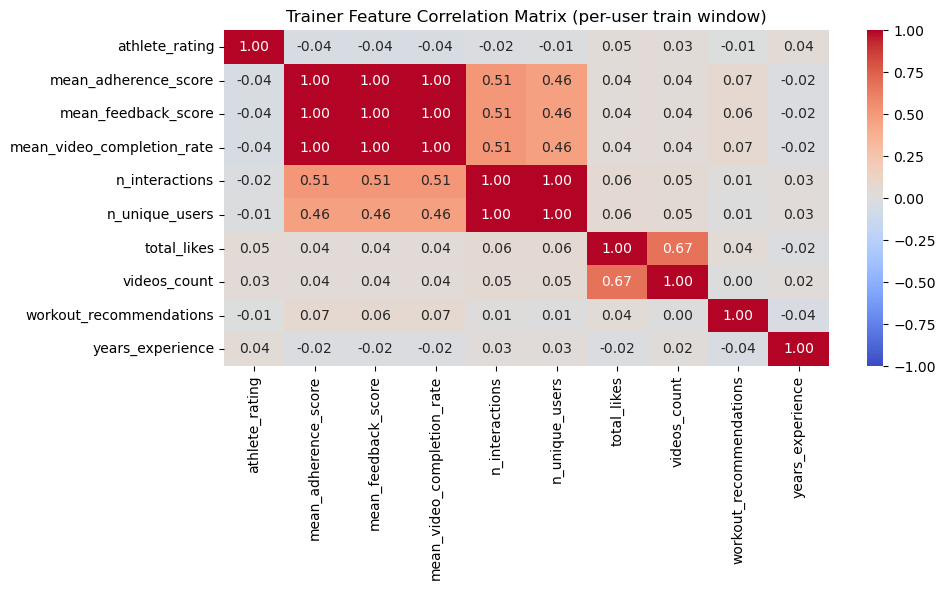


✅ UPDATED STEP 2 complete – per-user LL1 features & PCA ready.


In [3]:
                                                                           
                                                                           
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import joblib, os

                                                                             
                                                                                          
                                                                             
                                                           
df_engage = df_engage.copy()
df_engage["timestamp"] = pd.to_datetime(df_engage["timestamp"], utc=True, errors="coerce")
assert df_engage["timestamp"].notna().all(), "Found NaT timestamps in df_engage['timestamp']"

_ev = df_engage.sort_values(["user_id", "timestamp"]).copy()

                                    
last_ts = _ev.groupby("user_id")["timestamp"].max()
cutoff  = (last_ts - pd.Timedelta(days=7)).rename("cutoff")
_ev     = _ev.merge(cutoff.reset_index(), on="user_id", how="left")
_ev["_in_last7"] = _ev["timestamp"] >= _ev["cutoff"]

                                             
win_counts = _ev.groupby("user_id")["_in_last7"].sum()
ok_users   = win_counts[win_counts >= 2].index
fb_users   = win_counts[win_counts <  2].index                                  

                                                                                                   
order_cols = ["user_id", "timestamp"]
if "interaction_id" in _ev.columns:
    order_cols.append("interaction_id")
else:
    _ev["_rownum"] = _ev.groupby("user_id").cumcount()
    order_cols.append("_rownum")

last_idx_fb = (
    _ev.loc[_ev["user_id"].isin(fb_users)]
       .sort_values(order_cols)
       .groupby("user_id", as_index=False)
       .tail(1)
       .index
)

            
test_mask  = (_ev["_in_last7"] & _ev["user_id"].isin(ok_users)) | (_ev.index.isin(last_idx_fb))
train_mask = ~test_mask

drop_cols = ["cutoff","_in_last7"]
if "_rownum" in _ev.columns: drop_cols.append("_rownum")

df_eng_train = _ev.loc[train_mask].drop(columns=drop_cols, errors="ignore").copy()
df_eng_test  = _ev.loc[test_mask ].drop(columns=drop_cols, errors="ignore").copy()

print(f"Per-user last_7_days (min2 + fallback) → Train: {len(df_eng_train):,} | Test: {len(df_eng_test):,}")

                         
assert set(df_eng_train.index).isdisjoint(set(df_eng_test.index)), "Train/Test indices overlap."
if len(df_eng_test):
                                                           
    _chk = df_eng_test.merge(
        df_eng_test.groupby("user_id")["timestamp"].max().rename("last_test_ts"),
        left_on="user_id", right_index=True, how="left"
    )
    assert (_chk["timestamp"] <= _chk["last_test_ts"]).all()
print("✅ Split checks passed.")

                                                                             
                                                                         
                                                                             
                                                              
agg_quality = (
    df_eng_train
      .groupby("trainer_id")
      .agg(
          mean_video_completion_rate = ("video_completion_rate", "mean"),
          mean_adherence_score       = ("adherence_score", "mean"),
          mean_feedback_raw          = ("feedback_score", "mean"),
          n_interactions             = ("trainer_id", "size"),
          n_unique_users             = ("user_id", "nunique"),
      )
      .reset_index()
)

                                       
agg_quality["mean_feedback_score"] = agg_quality["mean_feedback_raw"] / 5.0
agg_quality.drop(columns="mean_feedback_raw", inplace=True)

                                                                             
                                           
                                                                             
static_cols = [
    "trainer_id", "specialities", "videos_count", "total_likes",
    "workout_recommendations", "athlete_rating", "years_experience"
]
df_pt_static = df_pt[static_cols]

df_feat_raw = (
    df_pt_static
      .merge(agg_quality, on="trainer_id", how="left")
      .fillna(0)                                                
)

                                                                             
                                                                                      
                                                                             
feat_cols = df_feat_raw.columns.difference(["trainer_id", "specialities"])
features  = df_feat_raw[feat_cols].astype(float).copy()

scaler = StandardScaler()
X_std = scaler.fit_transform(features)

                                                                             
                                                             
                                                                             
pca_full = PCA().fit(X_std)
cum_var  = pca_full.explained_variance_ratio_.cumsum()
k = int(np.searchsorted(cum_var, 0.95) + 1)

pca = PCA(n_components=k).fit(X_std)
X_pca = pca.transform(X_std)

df_feat_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(k)])
df_feat_pca.insert(0, "trainer_id", df_feat_raw["trainer_id"].values)
df_feat_pca["specialities"] = df_feat_raw["specialities"].values

print(f"Retained {k} PCs (≥95 % variance).  df_feat_pca shape: {df_feat_pca.shape}")

                                                
os.makedirs("artifacts", exist_ok=True)
joblib.dump({"scaler": scaler, "pca": pca}, "artifacts/pca_bundle.pkl")

                                                                             
                                                               
                                                                             
plt.figure(figsize=(10,6))
corr = pd.DataFrame(X_std, columns=feat_cols).corr()
sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Trainer Feature Correlation Matrix (per-user train window)")
plt.tight_layout()
plt.show()

print("\n✅ UPDATED STEP 2 complete – per-user LL1 features & PCA ready.")


In [4]:
df_feat_raw.to_csv(str(DATA_DIR / 'df_feat_raw.csv'), index=False)


In [5]:
                                                              
                                                              
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
import joblib, os, re
from difflib import get_close_matches

                                                                            
                                                   
                                                                            
pc_cols = [c for c in df_feat_pca.columns if c.startswith("PC")]
pc_scaler = MinMaxScaler()
df_pc_scaled = df_feat_pca.copy()
df_pc_scaled[pc_cols] = pc_scaler.fit_transform(df_feat_pca[pc_cols])

                                                                            
                                                        
                                                                            
base_w = np.array([0.40, 0.20, 0.15, 0.15, 0.05, 0.05])
w_exp = base_w[:len(pc_cols)]
w_exp = w_exp / w_exp.sum()

                                                                            
                                                                            
                                                                            
y_target = df_feat_raw["mean_adherence_score"].values                      
ridge = Ridge(alpha=1.0, fit_intercept=False, positive=True)
ridge.fit(df_pc_scaled[pc_cols].values, y_target)
w_learn = ridge.coef_ / ridge.coef_.sum()

print("Expert  weights:", np.round(w_exp, 3))
print("Learned weights:", np.round(w_learn, 3))

                                                                            
                              
                                                                            
df_scores = df_pc_scaled[["trainer_id", "specialities"] + pc_cols].copy()
df_scores["score_expert"]  = df_pc_scaled[pc_cols].values @ w_exp
df_scores["score_learned"] = df_pc_scaled[pc_cols].values @ w_learn

print("\nTop-5 trainers – expert weights")
display(df_scores.sort_values("score_expert", ascending=False)
                 [["trainer_id", "score_expert"]].head())

print("\nTop-5 trainers – learned weights")
display(df_scores.sort_values("score_learned", ascending=False)
                 [["trainer_id", "score_learned"]].head())

                                                                            
                                                          
                                                                            
os.makedirs("artifacts", exist_ok=True)
np.save("artifacts/weights_expert.npy",  w_exp)
np.save("artifacts/weights_learned.npy", w_learn)
df_scores.to_csv(str(DATA_DIR / 'trainer_scores_train_window.csv'), index=False)
joblib.dump(pc_scaler, "artifacts/pc_minmax_scaler.pkl")

                                                                            
                                                                       
                                                                            
goal2tags = {
    "injury recovery & rehabilitation": ["rehabilitation", "physiotherapy", "functional training"],
    "strength building":               ["strength training", "powerlifting"],
    "muscle gain":                     ["muscle building", "bodybuilding"],
    "cardiovascular fitness":          ["cardio", "hiit", "crossfit"],
    "flexibility & mobility":          ["flexibility", "yoga", "pilates"],
    "general fitness & wellness":      ["functional training", "yoga", "pilates"],
    "weight management":               ["weight loss", "hiit", "cardio"],
    "stress reduction & mindfulness":  ["yoga", "pilates"],
    "prenatal & postnatal health":     ["prenatal fitness"],
    "healthy aging / senior wellness": ["elderly fitness", "functional training"],
    "athletic performance & sports rehab": ["sports-specific", "crossfit"],
    "aesthetic & physique goals":      ["bodybuilding", "muscle building"],
}

def _speciality_match(spec_string: str, goal: str) -> bool:
    """Exact → synonym dict → fuzzy (difflib) matching."""
    toks = [t.strip().lower() for t in re.split(r"[,&/]", spec_string)]
    goal_lc = goal.lower().strip()

                            
    if goal_lc in toks:
        return True

                           
    if goal_lc in goal2tags:
        if any(tag in toks for tag in goal2tags[goal_lc]):
            return True

                          
    return bool(get_close_matches(goal_lc, toks, cutoff=0.83))

def recommend(user_id: int, k: int = 5, variant: str = "expert") -> pd.DataFrame:
    """
    Return top-k trainers who serve the user’s health_goal.
    `variant` ∈ {'expert', 'learned'}.
    """
    if variant not in {"expert", "learned"}:
        raise ValueError("variant must be 'expert' or 'learned'")

    goal = df_user.loc[df_user.user_id == user_id, "health_goal"].iat[0]
    mask = df_scores["specialities"].apply(lambda s: _speciality_match(s, goal))
    score_col = f"score_{variant}"

    return (df_scores.loc[mask]
            .sort_values(score_col, ascending=False)
            .head(k)
            [["trainer_id", score_col]])

print("\nSmoke-test recommend() for user_id 42 (expert weights):")
display(recommend(42, k=5, variant="expert"))

print("\n✅ STEP 3 complete – synonym-aware recommender ready.")


Expert  weights: [0.4  0.2  0.15 0.15 0.05 0.05]
Learned weights: [0.623 0.023 0.    0.194 0.064 0.096]

Top-5 trainers – expert weights


,trainer_id,score_expert
747,748,0.742427
884,885,0.734567
796,797,0.727285
621,622,0.708216
844,845,0.702658



Top-5 trainers – learned weights


,trainer_id,score_learned
884,885,0.827980
621,622,0.786873
796,797,0.785981
718,719,0.784226
960,961,0.783908



Smoke-test recommend() for user_id 42 (expert weights):


,trainer_id,score_expert
747,748,0.742427
884,885,0.734567
796,797,0.727285
621,622,0.708216
844,845,0.702658



✅ STEP 3 complete – synonym-aware recommender ready.


In [6]:
                                                 
                                                 
import pandas as pd
import numpy as np
import os

                                                                              
gt = (df_eng_test
        .groupby("user_id")["trainer_id"]
        .apply(set)
        .rename("true_trainers"))

print(f"Evaluation users: {len(gt):,}")

                                                                             
pred_rows = []
for uid in gt.index:
    recs = recommend(uid, k=5, variant="learned")                                        
    pred_rows.append({
        "user_id": uid,
        "predicted_trainers": recs["trainer_id"].tolist()
    })

df_pred = pd.DataFrame(pred_rows).set_index("user_id")

                                                                              
def precision_at_5(pred_list, true_set):
    return len(set(pred_list) & true_set) / 5

scores = [
    precision_at_5(df_pred.loc[u, "predicted_trainers"], gt.loc[u])
    for u in gt.index if u in df_pred.index
]
mean_p5 = np.mean(scores)
print(f"\nMean Precision@5 (Hit-Rate@5) over {len(scores)} users: {mean_p5:.3f}")

                                                                              
os.makedirs("artifacts", exist_ok=True)
(df_pred.reset_index()
        .to_csv(str(DATA_DIR / 'recommendations_next_week.csv'), index=False))

print("\nTop 10 preview – recommendations for next week:")
display(df_pred.head(10))

print("\n✅ STEP 4 complete – per-user top-5 trainer lists saved to "
      "`artifacts/recommendations_next_week.csv`.")


Evaluation users: 40,000

Mean Precision@5 (Hit-Rate@5) over 40000 users: 0.024

Top 10 preview – recommendations for next week:


,predicted_trainers
user_id,
1,"[885, 622, 797, 961, 748]"
2,"[885, 622, 797, 719, 961]"
3,"[885, 622, 719, 961, 748]"
4,"[885, 622, 719, 961, 748]"
5,"[885, 622, 797, 719, 961]"
6,"[885, 622, 797, 719, 961]"
7,"[885, 622, 719, 961, 748]"
8,"[885, 622, 719, 961, 748]"
9,"[885, 622, 797, 719, 961]"



✅ STEP 4 complete – per-user top-5 trainer lists saved to `artifacts/recommendations_next_week.csv`.


In [7]:
                                                                   
                                                                   
import pandas as pd, numpy as np, json, os, re
from math import log2
from difflib import get_close_matches
from tqdm import tqdm

                                                                 
                                                                
                                                                 
def _ranked_list(user_id: int, variant: str = "expert") -> list:
    goal = df_user.loc[df_user.user_id == user_id, "health_goal"].iat[0]
    score_col = f"score_{variant}"
    mask = df_scores["specialities"].apply(
        lambda s: _speciality_match(s, goal)
    )
    return (df_scores.loc[mask]
                     .sort_values(score_col, ascending=False)
                     ["trainer_id"]
                     .tolist())

                                                                 
                                                         
                                                                 
def precision_at_k(relevant, ranked, k):
    return len(set(ranked[:k]) & relevant) / k

def recall_at_k(relevant, ranked, k):
    return len(set(ranked[:k]) & relevant) / len(relevant) if relevant else np.nan

def ndcg_at_k(relevant, ranked, k):
    if not relevant:
        return np.nan
    dcg = sum((1 if tid in relevant else 0) / log2(i+2)
              for i, tid in enumerate(ranked[:k]))
    ideal_hits = min(k, len(relevant))
    idcg = sum(1 / log2(i+2) for i in range(ideal_hits))
    return dcg / idcg if idcg else 0.0

def average_precision(relevant, ranked):
    hits, ap = 0, []
    for i, tid in enumerate(ranked, start=1):
        if tid in relevant:
            hits += 1
            ap.append(hits / i)
    return np.mean(ap) if ap else 0.0

TOP_KS = [5, 10]                                          

                                                                 
                                                       
                                                                 
user2truth = (df_eng_test
              .groupby("user_id")["trainer_id"]
              .apply(set)
              .to_dict())

                                                                 
                                                          
                                                                 
predictions = {"expert": {}, "learned": {}}
for var in predictions:
    for uid in tqdm(user2truth, desc=f"Scoring ({var})"):
        predictions[var][uid] = _ranked_list(uid, variant=var)

                                                                 
                                                 
                                                                 
metrics_rows = []

for var, per_user_rank in predictions.items():
    for uid, truth in user2truth.items():
        ranked = per_user_rank[uid]
        row = {
            "variant": var,
            "user_id": uid,
            "precision@5": precision_at_k(truth, ranked, 5),
            "precision@10": precision_at_k(truth, ranked, 10),
            "recall@5": recall_at_k(truth, ranked, 5),
            "recall@10": recall_at_k(truth, ranked, 10),
            "ndcg@5": ndcg_at_k(truth, ranked, 5),
            "ndcg@10": ndcg_at_k(truth, ranked, 10),
            "map": average_precision(truth, ranked)
        }
        metrics_rows.append(row)

df_metrics_user = pd.DataFrame(metrics_rows)

                                                           
df_metrics = (df_metrics_user
              .drop(columns="user_id")
              .groupby("variant")
              .mean()
              .round(4)
              .reset_index())

print("\n=== Macro-averaged metrics on each user’s held-out week ===")
display(df_metrics)

                                                                 
                      
                                                                 
os.makedirs("artifacts", exist_ok=True)

                           
df_pred = pd.DataFrame({
    "user_id": list(user2truth.keys()),
    "pred_expert_top5": [predictions["expert"][uid][:5]  for uid in user2truth],
    "pred_learned_top5": [predictions["learned"][uid][:5] for uid in user2truth],
    "truth_trainers": [list(user2truth[uid]) for uid in user2truth]
})
df_pred.to_csv(str(DATA_DIR / 'user_top5_predictions.csv'), index=False)

              
df_metrics.to_csv(str(DATA_DIR / 'evaluation_metrics.csv'), index=False)
with open(str(DATA_DIR / 'evaluation_metrics.json'), "w") as f:
    json.dump(df_metrics.to_dict(orient="records"), f, indent=2)

print("\n✅ STEP 4 complete – prediction & evaluation DataFrames saved.")


Scoring (learned): 100%|██████████| 40000/40000 [05:58<00:00, 111.48it/s]



=== Macro-averaged metrics on each user’s held-out week ===


,variant,precision@5,precision@10,recall@5,recall@10,ndcg@5,ndcg@10,map
0,expert,0.0224,0.0217,0.0282,0.0546,0.0272,0.0389,0.0432
1,learned,0.0244,0.0231,0.0307,0.0585,0.0295,0.0417,0.0460



✅ STEP 4 complete – prediction & evaluation DataFrames saved.


In [8]:
                                                                  

uid = 42
print(f"Health goal for user {uid}:",
      df_user.loc[df_user.user_id == uid, "health_goal"].iat[0])

print("\nTop-5 trainers (expert weights):")
display(recommend(user_id=uid, k=5, variant="expert"))

print("\nTop-5 trainers (learned weights):")
display(recommend(user_id=uid, k=5, variant="learned"))


Health goal for user 42: General Fitness & Wellness

Top-5 trainers (expert weights):


,trainer_id,score_expert
747,748,0.742427
884,885,0.734567
796,797,0.727285
621,622,0.708216
844,845,0.702658



Top-5 trainers (learned weights):


,trainer_id,score_learned
884,885,0.827980
621,622,0.786873
796,797,0.785981
718,719,0.784226
960,961,0.783908


In [ ]:
uid = 1
truth = user2truth[uid]
ranked = _ranked_list(uid, "learned")                     
print("Truth in candidate set:",
      len(set(truth) & set(ranked)) / len(truth))


Truth in candidate set: 1.0


In [ ]:
cold = df_eng_test[~df_eng_test.trainer_id.isin(df_eng_train.trainer_id)]
print("Cold-start interactions in test:", len(cold))


Cold-start interactions in test: 0


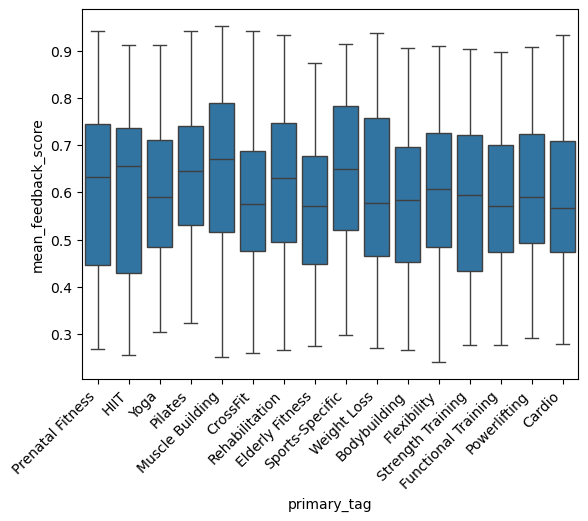

In [ ]:
import seaborn as sns, matplotlib.pyplot as plt
tmp = df_feat_raw.copy()
tmp["primary_tag"] = tmp["specialities"].str.split(",").str[0]
sns.boxplot(x="primary_tag", y="mean_feedback_score", data=tmp)
plt.xticks(rotation=45, ha="right"); plt.show()


In [ ]:
pd.read_csv(str(DATA_DIR / 'evaluation_metrics.csv')).set_index("variant")


,precision@5,precision@10,recall@5,recall@10,ndcg@5,ndcg@10,map
variant,,,,,,,
expert,0.0224,0.0217,0.0282,0.0546,0.0272,0.0389,0.0432
learned,0.0244,0.0231,0.0307,0.0585,0.0295,0.0417,0.0460
